# Create an Azure AI Content Safety __(AACS)__ enabled text-to-image online endpoint (Preview)

### This notebook is under preview.

### Steps to create an __AACS__ enabled __text-to-image__ online endpoint
1. Create an __AACS__ resource for moderating the request from user and response from the __text-to-image__ online endpoint.
2. Create a new __AACS__ enabled __inpainting__ online endpoint with a custom [score_online.py](./aacs-scoring-files/score/score_online.py) which will integrate with the __AACS__ resource to moderate the response from the __text-to-image__ models and the request from the user, but to make the custom [score_online.py](./aacs-scoring-files/score/score_online.py) to successfully authenticated to the __AACS__ resource, we have 2 options:
    1. __UAI__, recommended but more complex approach, is to create a User Assigned Identity (UAI) and assign appropriate roles to the UAI. Then, the custom [score_online.py](./aacs-scoring-files/score/score_online.py) can obtain the access token of the UAI from the AAD server to access the AACS resource. Use [this notebook](aacs-prepare-uai.ipynb) to create UAI account for step 3 below
    2. __Environment variable__, simpler but less secure approach, is to just pass the access key of the AACS resource to the custom [score_online.py](./aacs-scoring-files/score/score_online.py) via environment variable, then the custom [score_online.py](./aacs-scoring-files/score/score_online.py) can use the key directly to access the AACS resource, this option is less secure than the first option, if someone in your org has access to the endpoint, he/she can get the access key from the environment variable and use it to access the AACS resource.

### Task,
`text-to-image` task generates image as output based on text prompt given in input.

### Model
Models that can perform the `text-to-image` task are tagged with `text-to-image`. We will use the `runwayml-stable-diffusion-v1-5` model in this notebook. If you opened this notebook from a specific model card, remember to replace the specific model name.


### Outline
1. Setup pre-requisites
2. Create AACS resource
3. Pick a model to deploy
4. Deploy the model to an online endpoint for real time inference
5. Test the endpoint
6. Clean up resources - delete the online endpoint

### 1. Setup pre-requisites
* Check List
* Install dependencies
* Connect to AzureML Workspace. Learn more at [set up SDK authentication](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-setup-authentication?tabs=sdk). Replace  `<WORKSPACE_NAME>`, `<RESOURCE_GROUP>` and `<SUBSCRIPTION_ID>` below.
* Connect to `azureml` system registry

> [x] The identity you are using to execute this notebook(yourself or your VM) need to have the __Contributor__ role on the resource group where the AML Workspace your specified is located, because this notebook will create an AACS resource using that identity.

In [1]:
# Install the required packages
%pip install azure-identity==1.13.0
%pip install azure-mgmt-cognitiveservices==13.4.0
%pip install azure-ai-ml==1.11.1
%pip install azure-mgmt-msi==7.0.0
%pip install azure-mgmt-authorization==3.0.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [3]:
from azure.ai.ml import MLClient

try:
    workspace_ml_client = MLClient.from_config(credential=credential)
except Exception as ex:
    # enter details of your AML workspace
    subscription_id = "<SUBSCRIPTION_ID>"
    resource_group = "<RESOURCE_GROUP>"
    workspace = "<AML_WORKSPACE_NAME>"

    # get a handle to the workspace
    workspace_ml_client = MLClient(credential, subscription_id, resource_group, workspace)

subscription_id = workspace_ml_client.subscription_id
resource_group = workspace_ml_client.resource_group_name
workspace_name = workspace_ml_client.workspace_name

print(f"Connected to workspace {workspace_name}")

Found the config file in: .\config.json


Connected to workspace rv-images-ws


In [4]:
# The public registry name contains text-to-image models
registry_name = "azureml"

registry_ml_client = MLClient(
    credential,
    subscription_id=subscription_id,
    resource_group_name=resource_group,
    registry_name=registry_name,
)

### 2. Create AACS resource

#### 2.1 Assign variables for Azure Content Safety
Currently, AACS is available in a limited set of regions:


__NOTE__: before you choose the region to deploy the AACS, please be aware that your data will be transferred to the region you choose and by selecting a region outside your current location, you may be allowing the transmission of your data to regions outside your jurisdiction. It is important to note that data protection and privacy laws may vary between jurisdictions. Before proceeding, we strongly advise you to familiarize yourself with the local laws and regulations governing data transfer and ensure that you are legally permitted to transmit your data to an overseas location for processing. By continuing with the selection of a different region, you acknowledge that you have understood and accepted any potential risks associated with such data transmission. Please proceed with caution.

In [5]:
# The severity level that will trigger response be blocked
# Please reference Azure AI content documentation for more details
# https://learn.microsoft.com/en-us/azure/cognitive-services/content-safety/concepts/harm-categories
content_severity_threshold = "2"

# UAI to be used for endpoint if you choose to use UAI as authentication method.
# Use default name "aacs-uai" as used in prepare uai notebook

# uai_name = "aacs-uai"

# If you choose environment variables for authentication of AACS resource, then assign empty ("") value to uai_name
uai_name = ""

In [6]:
from uuid import uuid4
from azure.mgmt.cognitiveservices import CognitiveServicesManagementClient

aacs_client = CognitiveServicesManagementClient(credential, subscription_id)


# settings for the Azure AI Content Safety (AACS) resource
# we will choose existing AACS resource if it exists, otherwise create a new one
# name of AACS resource, has to be unique

aacs_name = f"aacs-text-to-image-{str(uuid4())[:8]}"
available_aacs_locations = ["east us", "west europe"]

# create a new Cognitive Services Account
kind = "ContentSafety"
aacs_sku_name = "S0"
aacs_location = available_aacs_locations[0]


print("Available SKUs:")
aacs_skus = aacs_client.resource_skus.list()
print("SKU Name\tSKU Tier\tLocations")
for sku in aacs_skus:
    if sku.kind == "ContentSafety":
        locations = ",".join(sku.locations)
        print(sku.name + "\t\t" + sku.tier + "\t\t" + locations)

print(f"Choose a new AACS resource in {aacs_location} with SKU {aacs_sku_name}")

Available SKUs:
SKU Name	SKU Tier	Locations


F0		Free		AUSTRALIAEAST
F0		Free		CANADAEAST
F0		Free		CENTRALUS
F0		Free		CENTRALUSEUAP
F0		Free		EASTUS
F0		Free		EASTUS2
F0		Free		EASTUS2EUAP
F0		Free		FRANCECENTRAL
F0		Free		JAPANEAST
F0		Free		NORTHCENTRALUS
F0		Free		SOUTHCENTRALUS
F0		Free		SWEDENCENTRAL
F0		Free		SWITZERLANDNORTH
F0		Free		UKSOUTH
F0		Free		WESTEUROPE
F0		Free		WESTUS
F0		Free		WESTUS2
F0		Free		WESTUS2
F0		Free		WESTUS3
S0		Standard		AUSTRALIAEAST
S0		Standard		CANADAEAST
S0		Standard		CENTRALUS
S0		Standard		CENTRALUSEUAP
S0		Standard		EASTUS
S0		Standard		EASTUS2
S0		Standard		EASTUS2EUAP
S0		Standard		FRANCECENTRAL
S0		Standard		JAPANEAST
S0		Standard		NORTHCENTRALUS
S0		Standard		SOUTHCENTRALUS
S0		Standard		SWEDENCENTRAL
S0		Standard		SWITZERLANDNORTH
S0		Standard		UKSOUTH
S0		Standard		WESTEUROPE
S0		Standard		WESTUS
S0		Standard		WESTUS2
S0		Standard		WESTUS2
S0		Standard		WESTUS3
Choose a new AACS resource in east us with SKU S0


#### 2.2 Create AACS Resource

In [7]:
from azure.mgmt.cognitiveservices.models import Account, Sku, AccountProperties


parameters = Account(
    sku=Sku(name=aacs_sku_name),
    kind=kind,
    location=aacs_location,
    properties=AccountProperties(
        custom_sub_domain_name=aacs_name, public_network_access="Enabled"
    ),
)


def find_acs(accounts):
    return next(
        x
        for x in accounts
        if x.kind == "ContentSafety"
        and x.location == aacs_location
        and x.sku.name == aacs_sku_name
    )


try:
    # check if AACS exists
    aacs = aacs_client.accounts.get(resource_group, aacs_name)
    print(f"Found existing AACS Account {aacs.name}.")
except:
    try:
        # check if there is an existing AACS resource within same resource group
        aacs = find_acs(aacs_client.accounts.list_by_resource_group(resource_group))
        print(
            f"Found existing AACS Account {aacs.name} in resource group {resource_group}."
        )
    except:
        print(f"Creating AACS Account {aacs_name}.")
        aacs_client.accounts.begin_create(resource_group, aacs_name, parameters).wait()
        print("Resource created.")
        aacs = aacs_client.accounts.get(resource_group, aacs_name)

Found existing AACS Account aacs-image-to-image-5ee94784 in resource group rv-images-rc.


In [8]:
aacs_endpoint = aacs.properties.endpoint
aacs_resource_id = aacs.id
aacs_name = aacs.name
print(
    f"AACS name is {aacs.name}, use this name in UAI preparation notebook to create UAI."
)
print(f"AACS endpoint is {aacs_endpoint}")
print(f"AACS ResourceId is {aacs_resource_id}")

aacs_access_key = aacs_client.accounts.list_keys(
    resource_group_name=resource_group, account_name=aacs.name
).key1

AACS name is aacs-image-to-image-5ee94784, use this name in UAI preparation notebook to create UAI.
AACS endpoint is https://aacs-image-to-image-5ee94784.cognitiveservices.azure.com/
AACS ResourceId is /subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/rv-images-rc/providers/Microsoft.CognitiveServices/accounts/aacs-image-to-image-5ee94784


#### 2.3 Check if UAI is used (Required for using UAI authentication method)

In [9]:
uai_id = ""
uai_client_id = ""
if uai_name != "":
    from azure.mgmt.msi import ManagedServiceIdentityClient
    from azure.mgmt.msi.models import Identity

    try:
        msi_client = ManagedServiceIdentityClient(
            subscription_id=subscription_id,
            credential=credential,
        )
        uai_resource = msi_client.user_assigned_identities.get(resource_group, uai_name)
        uai_id = uai_resource.id
        uai_client_id = uai_resource.client_id
    except Exception as ex:
        print("Please run aacs-prepare-uai.ipynb notebook and re-run the cell.")
        raise ex

### 3. Pick a model to deploy

Browse models in the Model Catalog in the AzureML Studio, filtering by the `text-to-image` task. In this example, we use the `runwayml-stable-diffusion-v1-5` model. If you have opened this notebook for a different model, replace the model name accordingly. This is a pre-trained model.

In [10]:
# Name of the text-to-image model to be deployed
model_name = "runwayml-stable-diffusion-v1-5"

try:
    model = registry_ml_client.models.get(model_name, label="latest")
    print(
        f"Using model name: {model.name}, version: {model.version}, id: {model.id} for inference."
    )
except Exception as ex:
    print(
        f"No model named {model_name} found in registry. "
        "Please check model name present in Azure model catalog"
    )
    raise ex

print(
    f"\n\nUsing model name: {model.name}, version: {model.version}, id: {model.id} for generating images from text."
)

Using model name: runwayml-stable-diffusion-v1-5, version: 4, id: azureml://registries/azureml/models/runwayml-stable-diffusion-v1-5/versions/4 for inference.


Using model name: runwayml-stable-diffusion-v1-5, version: 4, id: azureml://registries/azureml/models/runwayml-stable-diffusion-v1-5/versions/4 for generating images from text.


#### 3.1 Download and Register Model in Workspace

The above retrieved model from `azureml` registry will be registered within the user’s workspace. This registration will maintain the original name of the model, assign a unique version identifier (corresponding to the first field of the UUID), and label it as the “latest” version. Please note that this step take several minutes.

Following pipeline will download the model from the registry to the workspace and register it.

In [11]:
from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

compute_target = "cpu-cluster"
try:
    _ = workspace_ml_client.compute.get(compute_target)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=compute_target,
        type="amlcompute",
        size="Standard_D12_v2",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4,
    )
    workspace_ml_client.begin_create_or_update(compute_config).result()

Found existing compute target.


In [12]:
from azure.ai.ml import load_component

parent_dir = "./aacs-scoring-files/model_download_component"
download_model = load_component(source=parent_dir + "/download_model_and_register.yml")
download_model_component = workspace_ml_client.components.create_or_update(
    download_model
)
download_model_component

CommandComponent({'intellectual_property': None, 'auto_increment_version': False, 'source': 'REMOTE.WORKSPACE.COMPONENT', 'is_anonymous': False, 'auto_delete_setting': None, 'name': 'download_and_register_model', 'description': 'Component downloads and registers model to workspace for deployement purpose', 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/rv-images-rc/providers/Microsoft.MachineLearningServices/workspaces/rv-images-ws/components/download_and_register_model/versions/0.0.13', 'Resource__source_path': None, 'base_path': 'c:\\Users\\rvadthyavath\\work\\projects\\examples\\azureml-examples\\sdk\\python\\foundation-models\\system\\inference\\text-to-image', 'creation_context': <azure.ai.ml._restclient.v2022_10_01.models._models_py3.SystemData object at 0x000001ACC5FC9A00>, 'serialize': <msrest.serialization.Serializer object at 0x000001ACC5FC9DC0>, 'command': 'python download_model_to_ws.py --regist

In [13]:
from azure.ai.ml.dsl import pipeline

# define a pipeline containing 1 node
@pipeline(
    default_compute=compute_target,
)
def download_and_register_model_pipeline(
    registry_name,
    subscription_id,
    resource_group,
    workspace_name,
    model_name,
):
    """Pipeline for model download and register to workspace"""
    download_component = download_model_component(
        registry_name=registry_name,
        subscription_id=subscription_id,
        resource_group=resource_group,
        workspace_name=workspace_name,
        model_name=model_name,
    )

# create a pipeline
pipeline_job = download_and_register_model_pipeline(
    registry_name,
    subscription_id,
    resource_group,
    workspace_name,
    model_name,
)

In [14]:
pipeline_job = workspace_ml_client.jobs.create_or_update(
    pipeline_job, experiment_name="download_and_register_model"
)
pipeline_job

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


Experiment,Name,Type,Status,Details Page
download_and_register_model,purple_beard_9mx7r9y90l,pipeline,Preparing,Link to Azure Machine Learning studio


In [15]:
# wait until the job completes
workspace_ml_client.jobs.stream(pipeline_job.name)

RunId: purple_beard_9mx7r9y90l
Web View: https://ml.azure.com/runs/purple_beard_9mx7r9y90l?wsid=/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/rv-images-rc/workspaces/rv-images-ws

Streaming logs/azureml/executionlogs.txt

[2023-11-30 09:13:59Z] Submitting 1 runs, first five are: 36cee4dc:52d3bff0-4727-41d2-8173-8eca5d83250c
[2023-11-30 09:41:02Z] Completing processing run id 52d3bff0-4727-41d2-8173-8eca5d83250c.

Execution Summary
RunId: purple_beard_9mx7r9y90l
Web View: https://ml.azure.com/runs/purple_beard_9mx7r9y90l?wsid=/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/rv-images-rc/workspaces/rv-images-ws



In [16]:
# Get the model to be deployed from the workspace

try:
    model = workspace_ml_client.models.get(name=model.name, label="latest")
except Exception as ex:
    print(
        f"No model named {model_name} found in registry. "
        "Please check model name present in Azure model catalog"
    )
    raise ex

print(
    f"\n\nUsing model name: {model.name}, version: {model.version}, id: {model.id} for generating images from image-text."
)



Using model name: runwayml-stable-diffusion-v1-5, version: 3936435303, id: /subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/rv-images-rc/providers/Microsoft.MachineLearningServices/workspaces/rv-images-ws/models/runwayml-stable-diffusion-v1-5/versions/3936435303 for generating images from image-text.


### 4. Deploy the model to an online endpoint for real time inference
Online endpoints give a durable REST API that can be used to integrate with applications that need to use the model.

Create an online endpoint

In [17]:
# Endpoint names need to be unique in a region,
# hence using uuid (first 8 character) to create unique endpoint name

endpoint_name = (
    f"safe-text-to-image-{str(uuid4())[:8]}"  # Replace with your endpoint name
)

In [18]:
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    IdentityConfiguration,
    ManagedIdentityConfiguration,
)

# Check if the endpoint already exists in the workspace
try:
    endpoint = workspace_ml_client.online_endpoints.get(endpoint_name)
    print("---Endpoint already exists---")
except:
    # Create an online endpoint if it doesn't exist

    # Define the endpoint
    endpoint = ManagedOnlineEndpoint(
        name=endpoint_name,
        description=f"Test endpoint for {model.name}",
        identity=IdentityConfiguration(
            type="user_assigned",
            user_assigned_identities=[ManagedIdentityConfiguration(resource_id=uai_id)],
        )
        if uai_id != ""
        else None,
    )

    # Trigger the endpoint creation
    try:
        workspace_ml_client.begin_create_or_update(endpoint).wait()
        print("\n---Endpoint created successfully---\n")
    except Exception as err:
        raise RuntimeError(
            f"Endpoint creation failed. Detailed Response:\n{err}"
        ) from err


---Endpoint created successfully---



Create a deployment. This step may take a several minutes.

In [19]:
# Initialize deployment parameters
deployment_name = "text-to-image-deploy"

sku_name = "STANDARD_NC6S_V3"  # Name of the sku(instance type). Check the model card in catalog to get the most optimal sku for model.

REQUEST_TIMEOUT_MS = 90000

deployment_env_vars = {
    "CONTENT_SAFETY_ACCOUNT_NAME": aacs_name,
    "CONTENT_SAFETY_ENDPOINT": aacs_endpoint,
    "CONTENT_SAFETY_KEY": aacs_access_key if uai_client_id == "" else None,
    "CONTENT_SAFETY_THRESHOLD": content_severity_threshold,
    "SUBSCRIPTION_ID": subscription_id,
    "RESOURCE_GROUP_NAME": resource_group,
    "UAI_CLIENT_ID": uai_client_id,
}

In [20]:
from azure.ai.ml.entities import (
    OnlineRequestSettings,
    CodeConfiguration,
    ManagedOnlineDeployment,
    ProbeSettings,
)

code_configuration = CodeConfiguration(
    code="./aacs-scoring-files/score/", scoring_script="score_online.py"
)

deployment = ManagedOnlineDeployment(
    name=deployment_name,
    endpoint_name=endpoint_name,
    model=model.id,
    instance_type=sku_name,
    instance_count=1,
    code_configuration=code_configuration,
    environment_variables=deployment_env_vars,
    request_settings=OnlineRequestSettings(request_timeout_ms=REQUEST_TIMEOUT_MS),
    liveness_probe=ProbeSettings(
        failure_threshold=30,
        success_threshold=1,
        period=100,
        initial_delay=500,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=30,
        success_threshold=1,
        period=100,
        initial_delay=500,
    ),
)

# Trigger the deployment creation
try:
    workspace_ml_client.begin_create_or_update(deployment).wait()
    print("\n---Deployment created successfully---\n")
except Exception as err:
    raise RuntimeError(
        f"Deployment creation failed. Detailed Response:\n{err}"
    ) from err

Check: endpoint safe-text-to-image-d9d6b5bc exists


.....................................................................................................................................................................................................................................
---Deployment created successfully---



### 5. Test the endpoint

We will fetch some sample data from the test dataset and submit to online endpoint for inference.

#### 5.1 Sample input for safe prompt.

In [21]:
import json

request_json = {
    "input_data": {
        "columns": ["prompt"],
        "data": ["a photo of an astronaut riding a horse on mars"],
        "index": [0],
    }
}

# Create request json
request_file_name = "sample_request_data.json"
with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [22]:
response = workspace_ml_client.online_endpoints.invoke(
    endpoint_name=endpoint_name,
    deployment_name=deployment_name,
    request_file=request_file_name,
)

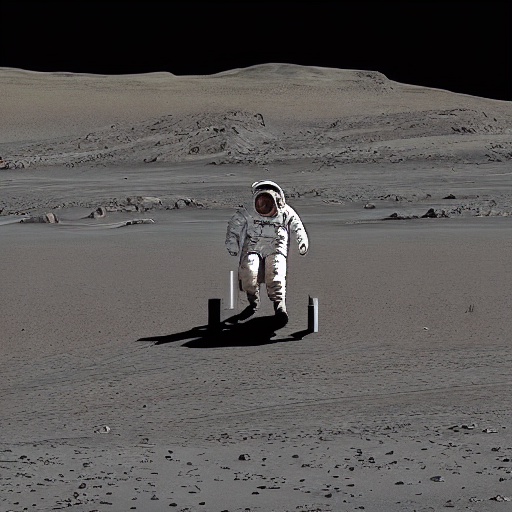

In [23]:
import io
import base64
from PIL import Image

generations = json.loads(response)
for generation in generations:
    img = Image.open(io.BytesIO(base64.b64decode(generation["generated_image"])))
    display(img)

#### 5.2 Sample input for un-safe prompt

In [24]:
## Blocked request/response due to violent content

import json

request_json = {
    "input_data": {
        "columns": ["prompt"],
        "data": [
            "Photograph of a dog with severed leg and bleeding profusely from deep laceration to the lower extremities, exposing tissues and nerve."
        ],
        "index": [0],
    }
}

# Create request json
request_file_name = "sample_request_data.json"
with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [25]:
response = workspace_ml_client.online_endpoints.invoke(
    endpoint_name=endpoint.name,
    deployment_name=deployment.name,
    request_file=request_file_name,
)

In [26]:
print(
    response
)  # Empty response as it is blocked by the Azure AI Content Safety (AACS) service.

{}


### 6. Clean up resources - delete the online endpoint
Don't forget to delete the online endpoint, else you will leave the billing meter running for the compute used by the endpoint.

In [27]:
workspace_ml_client.online_endpoints.begin_delete(name=endpoint.name).wait()

................................................................